# [CAT / NOT CAT](https://github.com/gabrielvv/imgpred)

BORDAGE MICKAEL  
VAUTRIN GABRIEL  
5A MOC1  
ESGI

# Collecter les données

## Sur Google Image

On peut récolter les images affichées sur Google Image
* exécuter le script javascript dans la console du browser sur la page Google Image, afin de récupérer la liste des urls
* **download_img** va télécharger toutes les images référencées dans la liste

In [3]:
%%js
// pull down jquery into the JavaScript console
var script = document.createElement('script');
script.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.2.0/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(script);

// grab the URLs
var urls = $('.rg_di .rg_meta').map(function() { return JSON.parse($(this).text()).ou; });

// write the URls to file (one per line)
var textToSave = urls.toArray().join('\n');
var hiddenElement = document.createElement('a');
hiddenElement.href = 'data:attachment/text,' + encodeURI(textToSave);
hiddenElement.target = '_blank';
hiddenElement.download = 'google_urls.txt';
hiddenElement.click();

<IPython.core.display.Javascript object>

In [4]:
from imutils import paths
import requests
import os

def download_img(urls_path, output_path, prefix="img"):
    # grab the list of URLs from the input file, then initialize the
    # total number of images downloaded thus far
    rows = open(urls_path).read().strip().split("\n")
    total = 0

    # loop the URLs
    for url in rows:
        try:
            # try to download the image
            r = requests.get(url, timeout=60)

            # save the image to disk
            p = os.path.sep.join([output_path, "{}.jpg".format(
                str(total).zfill(5))])
            f = open(p, "wb") # binary format
            f.write(r.content)
            f.close()

            # update the counter
            print("[INFO] downloaded: {}".format(p))
            total += 1

        # handle if any exceptions are thrown during the download process
        except:
            print("[INFO] error downloading {}...skipping".format(p))
            
# download("google_urls.txt", "tmp_img/cat", "google")

#### Nettoyage

* **clean_imgs** supprime les images que opencv n'arrive pas à lire
* contrôle visuel aléatoire (c'est impossible de s'assurer que 20000 images représentent bien ce qu'elles sont censés représenter)
* *ukbench* fournit des séries de 4 images du même objet dans les mêmes conditions avec quasiment le même angle de vue, on retire donc 3 images sur 4

In [5]:
from imutils import paths
import cv2
import os

def clean_imgs(directory_path):
    # loop over the image paths we just downloaded
    for image_path in paths.list_images(directory_path):
        # initialize if the image should be deleted or not
        delete = False

        # try to load the image
        try:
            image = cv2.imread(image_path)

            # if the image is `None` then we could not properly load it
            # from disk, so delete it
            if image is None:
                delete = True

        # if OpenCV cannot load the image then the image is likely
        # corrupt so we should delete it
        except:
            print("Except")
            delete = True

        # check to see if the image should be deleted
        if delete:
            print("[INFO] deleting {}".format(image_path))
            os.remove(image_path)
            
# clean_imgs("tmp_img/cat")

Au fil des recherches, nous avons récoltés les images suivantes parmi plusieurs datasets :

#### Cat

| Source | Total |
| --------------| -----------|
| [google image](https://www.google.com/search?q=cat&source=lnms&tbm=isch&sa=X&ved=0ahUKEwi8oKaNw5jYAhWG8RQKHVfoD7kQ_AUICigB&biw=1920&bih=968) | 610 |
| [imagenet](https://www.image-net.org/synset?wnid=n02121620) | 861 |
| [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) | 12500 |
| **total** | 13471 |

#### !Cat

| Source | Total |
| --------------| -----------|
| [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) | 9145 |
| [ukbench](https://archive.org/details/ukbench) | 2550 |
| **total** | 11694 |

#### Annotation

Le nom du répertoire où on stocke les images fait office d'annotation.
Les images de chat sont placées dans un répertoire **cat**.
Les images qui ne contiennent pas de chats sont placées dans un répertoire **not_cat**.

### Division en 2 sous-ensembles
* **train+validation** (9/10eme)
* **eval** (1/10eme) 

chacun contenant 50% de *cat* et 50% de *not_cat*

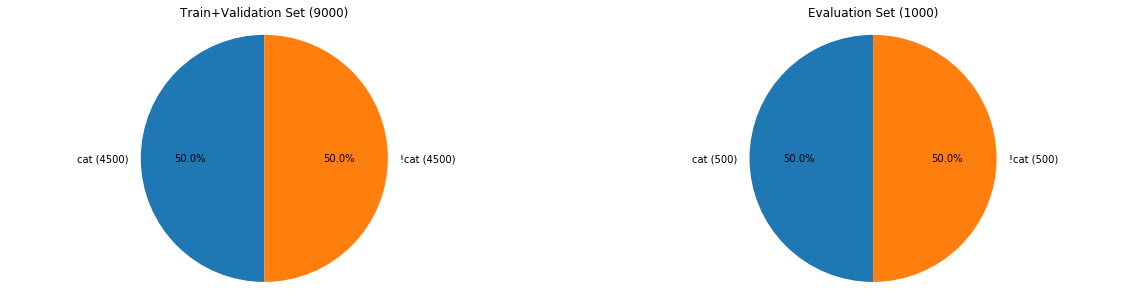

In [6]:
import warnings
warnings.filterwarnings('ignore')

# set the matplotlib backend so figures can be saved in the background
import matplotlib
# @see https://matplotlib.org/glossary/index.html#term-agg
matplotlib.use("Agg")
%matplotlib inline

from importlib import reload
from imgpred import gvutils
reload(gvutils)

gvutils.create_sets("tmp_img", "images")
gvutils.imgs_stats("images")

# Convolutional Neural Network

## Définition du réseau de neurones [LeNet](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/)

In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class LeNet:
    @staticmethod
    def build(width=28, height=28, depth=3, classes=2):
        #initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using 'channels first', update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

## [ConvNet](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

Nous nous sommes concentrés sur **LeNet** mais nous utilisons ConvNet pour tester l'aspect générique de certaines fonctions et comme élément de comparaison.

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

class ConvNet:
    @staticmethod
    def build(width=28, height=28, depth=3, classes=2):
        if K.image_data_format() == 'channels_first':
            input_shape = (depth, width, height)
        else:
            input_shape = (width, height, depth)

        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation('sigmoid'))

        return model

# Classification

## Définition des fonctions

In [9]:
#import warnings
#warnings.filterwarnings('ignore')

# set the matplotlib backend so figures can be saved in the background
import matplotlib
# @see https://matplotlib.org/glossary/index.html#term-agg
matplotlib.use("Agg")
%matplotlib inline

# import the necessary packages
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

from keras.models import load_model
import sys

La fonction **my_train_test_split** permet de créer un dataset équilibré et aléatoire à partir de toutes les images disponibles, avec éventuellement une quantité inférieure à la quantité d'images disponibles.
Les images sont converties en matrices et étiquetées.
On effectue ensuite un *train_test_split* sur ces données et on retourne le résultat.

In [10]:
def my_train_test_split(dataset_path, img_width, dataset_size=None):
    # init the data and labels
    print("[INFO] loading images...")
    data=[]
    labels=[]
    counter = [0,0]
    
    image_paths = sorted(list(paths.list_images(dataset_path)))
    random.seed(42)
    random.shuffle(image_paths)

    for image_path in image_paths:
        # os.path.sep => '\\' on Windows
        label = image_path.split(os.path.sep)[-2]
        label = 1 if label == "cat" else 0
        if label:
            counter[1] += 1
        if not label:
            counter[0] += 1
        
        if dataset_size:
            if counter[1] >= dataset_size/2 and counter[0] >= dataset_size/2:
                break;
            if label and counter[1] > dataset_size/2:
                continue;
            if not label and counter[0] > dataset_size/2:
                continue;
            
        img = cv2.imread(image_path)
        img = cv2.resize(img, (img_width, img_width))
        img = img_to_array(img)
        data.append(img)
        labels.append(label)

    # scale the raw pixel intensities to the range [0,1]
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

    # convert the labels from integers to vectors
    # [0,1,0] => [[1,0], [0,1], [1,0]]
    trainY = to_categorical(trainY, num_classes=2)
    testY = to_categorical(testY, num_classes=2)
    return (trainX, testX, trainY, testY)

m_filter = lambda arr,v: [it for it in arr if it[v] == 1]
#m_filter = lambda arr,v: np.extract(arr[v] == 1, arr)
#print(trainY) => le format est [[0,1],[0,1],[1,0],[0,1]...] après passage ds to_categorical
#(trainX, testX, trainY, testY) = my_train_test_split("images/train",28, dataset_size=100)
#print( "train:{0} (cat:{1}, not_cat:{2})".format(len(trainY),len(m_filter(trainY,1)),len(m_filter(trainY,0))) )
#print( "test:{0} (cat:{1}, not_cat:{2})".format(len(testY),len(m_filter(testY,1)),len(m_filter(testY,0))) )

#### train_network

In [11]:
def train_network(dataset_path, width, model_path, network_class=LeNet, params={}):
    # @see https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean
    # initialize the number of epochs to train for, initial learning rate,
    # and batch size
    EPOCHS = params.get("EPOCHS", 25) # training epochs
    INIT_LR = params.get("INIT_LR", 1e-3) # initial learning rate
    BS = params.get("BS", 32) # batch size
    verbose = params.get("verbose", 1)
    dataset_size = params.get("dataset_size", None)
    IMG_WIDTH = width

    if isinstance(dataset_path, str):
        (trainX, testX, trainY, testY) = my_train_test_split(dataset_path, IMG_WIDTH, dataset_size)
    else:
        (trainX, testX, trainY, testY) = dataset_path
        
    """
    construct the image generator for data augmentation
    @see https://keras.io/preprocessing/image/
    """
    aug = params.get("aug", ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest"))

    # init the model
    print("[INFO] compiling model...")
    model = network_class.build(width=IMG_WIDTH, height=IMG_WIDTH, depth=3, classes=2)

    """
    https://keras.io/optimizers/#adam
    https://arxiv.org/abs/1412.6980v8
    """
    opt = params.get("optimizer", Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS))

    """
    https://keras.io/losses/
    https://keras.io/metrics/
    https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
    https://en.wikipedia.org/wiki/Loss_function
    """
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network...")
    # https://keras.io/models/model/#fit_generator
    callbacks=[]
    if True:
        callbacks.append(TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BS, 
                                               write_graph=True, write_grads=False, write_images=False, 
                                               embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None))
    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS, epochs=EPOCHS, verbose=verbose, callbacks=callbacks)

    # save the model to disk
    print("[INFO] serializing network...")
    model.save(model_path)
    del model
    return (EPOCHS, H)


#train_network("images/train", 28, "models/cat_not_cat_XX.model", LeNet, {"verbose":0, "dataset_size":100})
#(trainX, testX, trainY, testY) = my_train_test_split("images/train", 28, 100)
#train_network((trainX, testX, trainY, testY), 28, "models/cat_not_cat_XX.model", LeNet, {"verbose":0})

#### test_network

In [12]:
from string import Template
import os
from imgpred import gvutils

def preprocess(img_path, width):
    # pre-process the image for classification
    image = cv2.imread(img_path)
    image = cv2.resize(image, (width, width))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.expand_dims.html
    image = np.expand_dims(image, axis=0)
    return image

def test_network(dataset_path, width, model_path, verbose=1):
    # load the trained convolutional neural network
    verbose and print("[INFO] loading network...")
    model = load_model(model_path)

    verbose and print("[INFO] testing images...")
    counter = 0
    # tableaux de tuples (img_path, pred_label)
    imgs = {"tp": [],"tn": [], "fp": [], "fn": []}
    y_true, y_pred = [], []
    for img_path in paths.list_images(dataset_path):
        # classify the input image
        (not_cat, cat) = model.predict(preprocess(img_path, width))[0]
        verbose and print("[INFO] {0:.2f} {1:.2f}".format(not_cat, cat))
        img_label = 1 if img_path.split(os.path.sep)[-2] == "cat" else 0
        y_true.append( img_label )
        y_pred.append(1 if cat > not_cat else 0)

        # Confusion Matrix for img reporting
        conf = "foo"
        if (cat > not_cat and img_label == 1):
            conf = "tp"
        elif (cat < not_cat and img_label == 0):
            conf = "tn"
        elif (cat > not_cat and img_label == 0):
            conf = "fp"
        elif (cat < not_cat and img_label == 1):
            conf = "fn"
        imgs[conf].append((img_path, gvutils.pred_label(cat, not_cat)))

        # Progress bar
        counter += 1
        verbose and gvutils.print_progress(counter, 0.02)

    del model
    return (y_true, y_pred, imgs)

#### Visualiser le résultat de l'ImageGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('images/train/cat/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 7:
        break  # otherwise the generator would loop indefinitely

<img width="100" src="./preview/cat_0_119.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">
<img width="100" src="./preview/cat_0_947.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">
<img width="100" src="./preview/cat_0_1873.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">
<img width="100" src="./preview/cat_0_5203.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;"><br/>
<img width="100" src="./preview/cat_0_2955.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">
<img width="100" src="./preview/cat_0_3026.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">
<img width="100" src="./preview/cat_0_9146.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">
<img width="100" src="./preview/cat_0_5535.jpeg" style="display: inline-block; padding: 5px; border-radius: 5px; box-shadow: -1px 1px 2px 1px #ccc;">

## Exploitation

### Entrainement

#### LeNet

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/25
210/210 [==============================] - 6s - loss: 0.6133 - acc: 0.6496 - val_loss: 0.5029 - val_acc: 0.7529
Epoch 2/25
210/210 [==============================] - 5s - loss: 0.5151 - acc: 0.7422 - val_loss: 0.4395 - val_acc: 0.7987
Epoch 3/25
210/210 [==============================] - 5s - loss: 0.4933 - acc: 0.7630 - val_loss: 0.4885 - val_acc: 0.7622
Epoch 4/25
210/210 [==============================] - 5s - loss: 0.4702 - acc: 0.7745 - val_loss: 0.4084 - val_acc: 0.8200
Epoch 5/25
210/210 [==============================] - 5s - loss: 0.4551 - acc: 0.7842 - val_loss: 0.3749 - val_acc: 0.8338
Epoch 6/25
210/210 [==============================] - 5s - loss: 0.4272 - acc: 0.8075 - val_loss: 0.4189 - val_acc: 0.8076
Epoch 7/25
210/210 [==============================] - 5s - loss: 0.4132 - acc: 0.8157 - val_loss: 0.4848 - val_acc: 0.7609
Epoch 8/25
210/210 [==============================] - 5s - lo

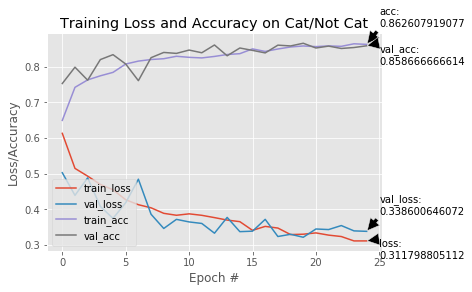

In [21]:
from imgpred import gvutils
from importlib import reload
reload(gvutils)

params = {
    "verbose": 1,
    "BS": 32,
    "EPOCHS": 25,
    "dataset_size": None
}

# %matplotlib inline
try_name = "lenet_BS32_EP25_28px_9000i"
(N, H) = train_network("images/train", 28, "models/{0}.model".format(try_name), LeNet, params)
gvutils.print_save_plot(N, H, "reporting/{0}.png".format(try_name))
#gvutils.imgs_stats("images")

#### ConvNet

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/25
210/210 [==============================] - 3s - loss: 0.6425 - acc: 0.6197 - val_loss: 0.5594 - val_acc: 0.7347
Epoch 2/25
210/210 [==============================] - 3s - loss: 0.5678 - acc: 0.7082 - val_loss: 0.5201 - val_acc: 0.7509
Epoch 3/25
210/210 [==============================] - 3s - loss: 0.5394 - acc: 0.7343 - val_loss: 0.5530 - val_acc: 0.7138
Epoch 4/25
210/210 [==============================] - 3s - loss: 0.5183 - acc: 0.7476 - val_loss: 0.5034 - val_acc: 0.7593
Epoch 5/25
210/210 [==============================] - 3s - loss: 0.5014 - acc: 0.7589 - val_loss: 0.6580 - val_acc: 0.6718
Epoch 6/25
210/210 [==============================] - 3s - loss: 0.4965 - acc: 0.7634 - val_loss: 0.4359 - val_acc: 0.8096
Epoch 7/25
210/210 [==============================] - 3s - loss: 0.4818 - acc: 0.7740 - val_loss: 0.4394 - val_acc: 0.8096
Epoch 8/25
210/210 [==============================] - 3s - lo

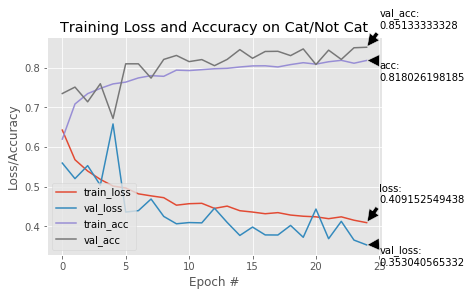

In [22]:
params = {
    "verbose": 1,
    "BS": 32,
    "EPOCHS": 25,
    "dataset_size": None,
    "optimizer": 'rmsprop'
}

try_name = "convnet_BS32_EP25_OPT_RMS_28px_9000i"
(N, H) = train_network("images/train", 28, "models/{0}.model".format(try_name), ConvNet, params)
gvutils.print_save_plot(N, H, "reporting/{0}.png".format(try_name))

### Evaluation

Confusion matrix, without normalization
[[478  22]
 [193 307]]


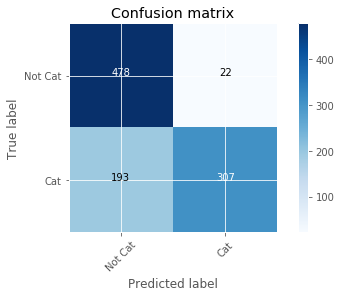

[INFO] accuracy=0.79


In [15]:
from imgpred import gvutils
# reload(gvutils)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# cat_not_cat_28px_2000i
# convnet_BS16_EP50_150px_1000i

(y_true, y_pred, imgs) = test_network("images/eval", 28, "models/{0}.model".format("lenet_BS32_EP25_28px_9000i"), False)
cm = confusion_matrix(y_true, y_pred)
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ravel.html
tn, fp, fn, tp = cm.ravel()
gvutils.plot_confusion_matrix(cm, classes=["Not Cat", "Cat"])
plt.show()
print("[INFO] accuracy={:.2f}".format(accuracy_score(y_true, y_pred)))

#print(str(imgs))
#gvutils.save_confusion_matrix_samples(imgs, "reporting/conf_matrix_XX.png")

![matrice de confusion](reporting/conf_matrix_XX.png)

La précision annoncée après l'entrainement du modèle est souvent légèrement différente de la précision obtenue sur de nouvelles images.

# GridSearch

## Taille du dataset et taille des images

Pour des images de 128px, l'entrainement devient long et on obient régulièrement une **ResourceExhaustedError**. Mais on peut relancer le gridsearch à partir du point qui a échoué.

In [ ]:
%load_ext autoreload
%autoreload
from imgpred import gvutils

gridsearch_result_file = "reporting/gridsearch24012018.json"
histories = []
dataset_sizes, img_sizes = range(3000,4000,500), [28, 64, 92]
#dataset_sizes, img_sizes = range(500,1000,500), [28,64,128]
for dataset_size in dataset_sizes:
    #gvutils.create_sets("tmp_img", "images", dataset_size)
    for img_size in img_sizes:
        """
        Attention il y un biais ici
        Les images des ensembles ne seront pas les mêmes parce qu'on doit redimensionner les images
        lors du split
        """
        print("======== [INFO] img_size:{0}px, dataset_size:{1} ===========".format(img_size,dataset_size))
        (trainX, testX, trainY, testY) = my_train_test_split("images/train", img_size, dataset_size)
        (N, H) = train_network(
            (trainX, testX, trainY, testY),
            img_size, 
            "models/cat_not_cat_{0}px_{1}i.model".format(img_size,dataset_size), 
            LeNet,
            {"verbose": 0}
        )
        #gvutils.print_save_plot(N, H, "reporting/plot_{0}px_{1}i.png".format(img_size,dataset_size))
        histories.append({
           "img_size": img_size,
            "dataset_size": dataset_size,
            "val_loss": H.history["val_loss"][-1],
            "loss": H.history["loss"][-1],
            "acc": H.history["acc"][-1],
            "val_acc": H.history["val_acc"][-1],
        })
        gvutils.list_to_file(gridsearch_result_file, [histories[-1]], "+")

Le résultat du *gridsearch* est stocké dans un fichier json qu'on peut relire ensuite pour afficher les résultats.

In [ ]:
dataset_sizes, img_sizes = range(500,3001,500), [28, 64, 128]
gvutils.read_matrix("reporting/gridsearch23012018.json", "reporting/plot_gs24012018.png", dataset_sizes, img_sizes)

![grid_plot](reporting/plot_gs24012018.png)

## [Hyper-paramètres Keras](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# @see https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 25 # training epochs
INIT_LR = 1e-3 # initial learning rate
BS = 32 # batch size

# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
def create_model():
    model = LeNet.build()
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BS, verbose=0)

(trainX, testX, trainY, testY) = my_train_test_split("images/train", 28, dataset_size=500)
print("[INFO] data split done")

# cf. http://cs231n.github.io/neural-networks-3/
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

[INFO] loading images...
[INFO] data split done


In [24]:
grid_result = grid.fit(trainX, trainY)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.711230 using {'batch_size': 80, 'epochs': 100}
0.676471 (0.038124) with: {'batch_size': 10, 'epochs': 10}
0.708556 (0.033871) with: {'batch_size': 10, 'epochs': 50}
0.700535 (0.033331) with: {'batch_size': 10, 'epochs': 100}
0.636364 (0.014064) with: {'batch_size': 20, 'epochs': 10}
0.708556 (0.032813) with: {'batch_size': 20, 'epochs': 50}
0.692513 (0.036545) with: {'batch_size': 20, 'epochs': 100}
0.692513 (0.022064) with: {'batch_size': 40, 'epochs': 10}
0.703209 (0.056607) with: {'batch_size': 40, 'epochs': 50}
0.687166 (0.045375) with: {'batch_size': 40, 'epochs': 100}
0.596257 (0.044754) with: {'batch_size': 60, 'epochs': 10}
0.689840 (0.038390) with: {'batch_size': 60, 'epochs': 50}
0.681818 (0.019117) with: {'batch_size': 60, 'epochs': 100}
0.631016 (0.032681) with: {'batch_size': 80, 'epochs': 10}
0.692513 (0.022231) with: {'batch_size': 80, 'epochs': 50}
0.711230 (0.034994) with: {'batch_size': 80, 'epochs': 100}
0.681818 (0.067788) with: {'batch_size': 100, 'epochs':

## Résultats

### LeNet

| N°| Res | Training Set Size (cat/not_cat) | Test Set Size (cat/not_cat) | Accuracy (train/val/eval) | Divers |
| --| ----| ------------------| --------------| ---------| -------|
| 1 | 28 | 637/637* | 144/530| \*/\*/0.66 | BS=25 EPOCHS=32 |
| 2 | 28 | 637/626 | 144/530 | \*/\*/0.75 ||
| 3 | 28 | 637/626 | 144/530 | \*/\*/0.77 | tensorflow gpu |
| 4 | 64 | 637/626 | 144/530| \*/\*/0.77 | tensorflow gpu |
| 5 | 28 | 361/361 | 361/361| \*/\*/0.79 ||
| 6 | 28 | 2295/2295 | 255/255 | \*/\*/0.87 |_|
| 7 | 28 | 4500/4500 | 500/500 | \*/0.864/0.88 | BS=25 EPOCHS=32 |
| 8 | 28 | 1000/1000 | 500/500 | 0.90/0.825/0.83 | BS=50 EPOCHS=80 |
| 9 | 28 | 4500/4500 | 500/500 | 0.92/0.86/0.88 | BS=50 EPOCHS=80 |
| 10 | 28 | 500/500 | 500/500 | 0.88/0.78/0.84 | BS=50 EPOCHS=80 |
| 11 | 28 | 500/500 | 500/500 | 0.888/0.808/0.83 | BS=50 EPOCHS=80 OPT='rmsprop' |

### ConvNet

| N°| Res | Training Set Size (cat/not_cat) | Test Set Size (cat/not_cat) | Accuracy (train/val/test) | Divers |
| --| ----| ------------------| --------------| ---------| -------|
| 1 | 150 | 500/500 | 500/500 | 0.86/0.80/0.83 | BS=16 EPOCHS=50 OPT='rmsprop' |